_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
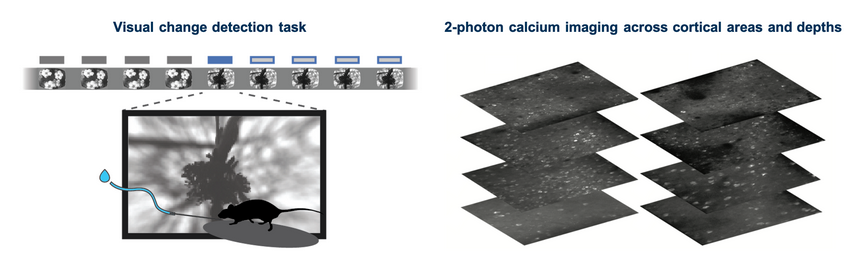

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

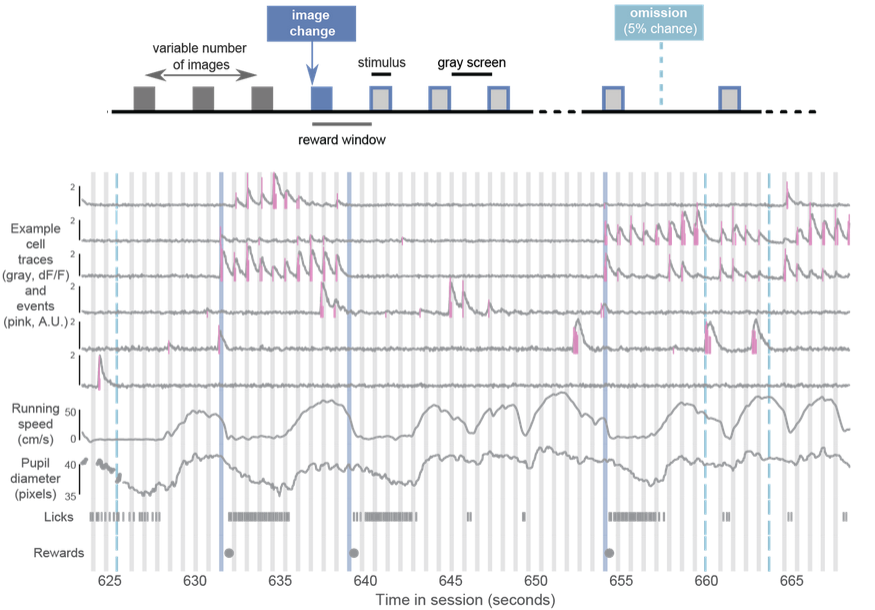

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [1]:
# load data
import numpy as np
import pandas as pd
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

In [65]:
import utils as U
import importlib

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions

<module 'utils' from '/Users/ahmedeldably/Downloads/Degrees/MSc/universities/Universität_Tübingen/Modules/spring_semester_25/GTC/NeuralـDataـScience/Coding_Labs/nds-final-project-summer25/utils.py'>

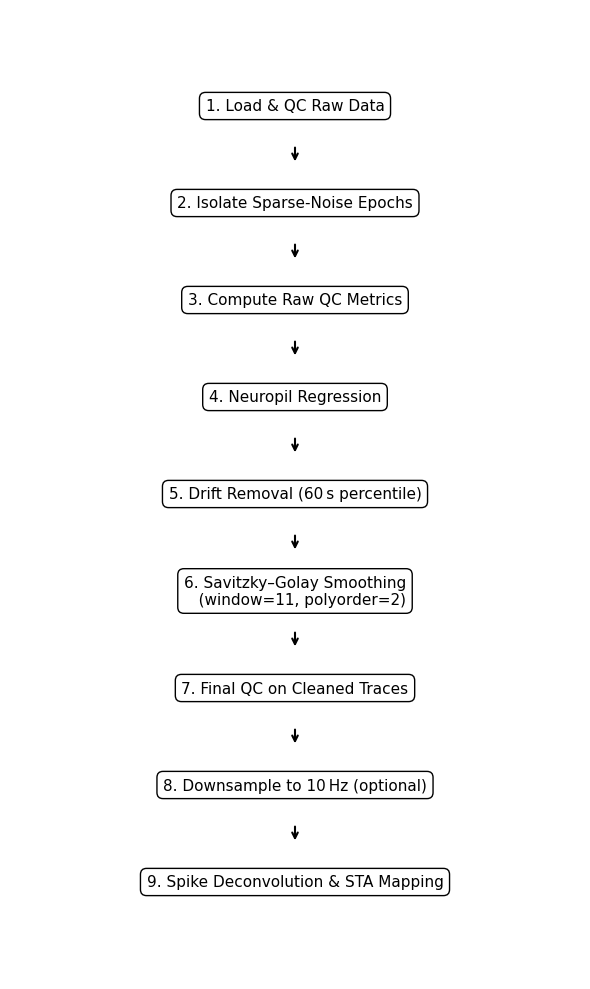

In [3]:
import matplotlib.pyplot as plt

# Define steps for the pipeline
steps = [
    "1. Load & QC Raw Data",
    "2. Isolate Sparse‑Noise Epochs",
    "3. Compute Raw QC Metrics",
    "4. Neuropil Regression",
    "5. Drift Removal (60 s percentile)",
    "6. Savitzky–Golay Smoothing\n   (window=11, polyorder=2)",
    "7. Final QC on Cleaned Traces",
    "8. Downsample to 10 Hz (optional)",
    "9. Spike Deconvolution & STA Mapping",
]

# Create figure
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis("off")

# Vertical positions
y_positions = np.linspace(0.9, 0.1, len(steps))

# Draw boxes and arrows
for i, (step, y) in enumerate(zip(steps, y_positions)):
    ax.text(
        0.5,
        y,
        step,
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="black"),
        fontsize=11,
    )
    if i < len(steps) - 1:
        next_y = y_positions[i + 1]
        ax.annotate(
            "",
            xy=(0.5, next_y + 0.04),
            xytext=(0.5, y - 0.04),
            arrowprops=dict(arrowstyle="->", lw=1.5),
        )

plt.tight_layout()
plt.show()

# 1. Setup & Data I/O

## 1.1 Imports & File Paths

In [4]:
# import packages here
import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

# File paths
paths = {
    "dff": "data/dff.npy",
    "t": "data/t.npy",
    "stim": "data/stim.npy",
    "stim_table": "data/stim_table.npy",
    "stim_epoch_table": "data/stim_epoch_table.npy",
    "roi_masks": "data/roi_masks.npy",
    "max_projection": "data/max_projection.npy",
    "running_speed": "data/running_speed.npy",
}

## 1.2 Load Data & Quick Shape Check

In [5]:
from utils import load_data

data = load_data(paths)

print("dff:", data["dff"].shape)
print("t:", data["t"].shape)
print("stim:", data["stim"].shape)
print("stim_table:", data["stim_table"].shape)
print("stim_epoch_table:", data["stim_epoch_table"].shape)
print("First stim_epoch_table row:", data["stim_epoch_table"][0])

dff: (189, 105968)
t: (105968,)
stim: (9000, 16, 28)
stim_table: (8880, 3)
stim_epoch_table: (7, 3)
First stim_epoch_table row: ['locally_sparse_noise' 737 22461]


## 1.3 Isolate “locally_sparse_noise” Epochs

In [6]:
from utils import isolate_sparse_epochs, compute_qc_metrics


mask = isolate_sparse_epochs(data, target="locally_sparse_noise")
dff_sparse = data["dff"][:, mask]
t_sparse = data["t"][mask]
print(f"Sparse‑noise frames: {mask.sum()}")

var_raw, snr_raw = compute_qc_metrics(dff_sparse)

data.update(
    {
        "mask_sparse": mask,
        "dff_sparse": dff_sparse,
        "t_sparse": t_sparse,
        "var_raw": var_raw,
        "snr_raw": snr_raw,
    }
)

Sparse‑noise frames: 66981


## 1.4 Repair & Store Running Speed

In [7]:
rs = data["running_speed"]  # shape: (2, T)
n_nans = [np.isnan(r).sum() for r in rs]
print(f"NaNs in running_speed rows: {n_nans}")

# pick the row with fewer NaNs as time
if n_nans[0] < n_nans[1]:
    run_t, run_speed = rs
else:
    run_speed, run_t = rs

run_speed = np.nan_to_num(run_speed, nan=0.0)

data.update(
    {
        "run_t": run_t,
        "run_speed": run_speed,
    }
)

print("run_t[:5]:    ", run_t[:5])
print("run_speed[:5]:", run_speed[:5])

NaNs in running_speed rows: [299, 0]
run_t[:5]:     [9.33015 9.36332 9.39649 9.42967 9.46284]
run_speed[:5]: [0. 0. 0. 0. 0.]


## 1.5 Flag “Good” vs. “Bad” Cells for Plotting


In [8]:
var_thr_raw = np.percentile(var_raw, 10)
snr_thr_raw = np.percentile(snr_raw, 10)
all_cells = np.arange(data["dff"].shape[0])
good_cells = np.where((var_raw > var_thr_raw) & (snr_raw > snr_thr_raw))[0]
bad_cells = np.setdiff1d(all_cells, good_cells)

print(f"Kept {len(good_cells)}/{len(all_cells)} cells after raw QC")

data.update(
    {
        "var_thr_raw": var_thr_raw,
        "snr_thr_raw": snr_thr_raw,
        "good_cells": good_cells,
        "bad_cells": bad_cells,
    }
)

Kept 151/189 cells after raw QC


## 1.6 Plotting

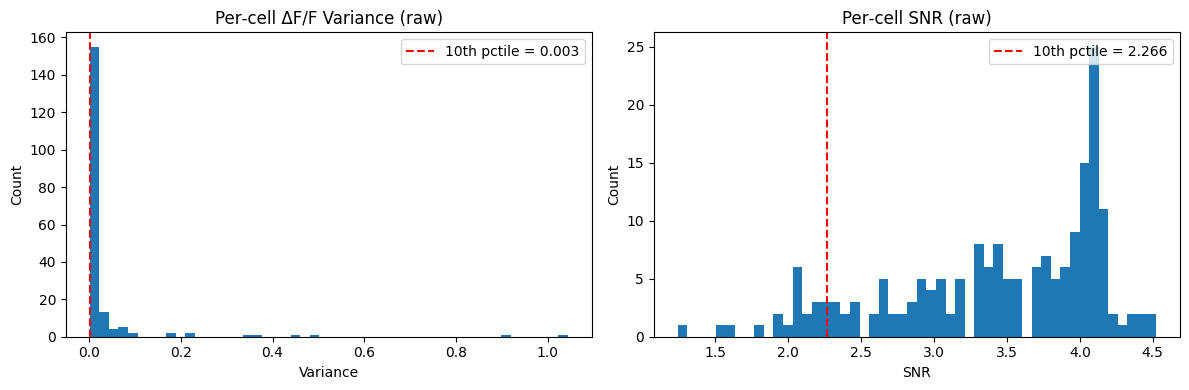

In [9]:
# QC — Raw ΔF/F Variance & SNR Distributions

# recompute 10th‑percentile thresholds on the raw metrics
var_thr_raw = np.percentile(data["var_raw"], 10)
snr_thr_raw = np.percentile(data["snr_raw"], 10)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Variance (raw)
axs[0].hist(data["var_raw"], bins=50)
axs[0].axvline(
    var_thr_raw, color="r", linestyle="--", label=f"10th pctile = {var_thr_raw:.3f}"
)
axs[0].set_title("Per‑cell ΔF/F Variance (raw)")
axs[0].set_xlabel("Variance")
axs[0].set_ylabel("Count")
axs[0].legend()

# SNR (raw)
axs[1].hist(data["snr_raw"], bins=50)
axs[1].axvline(
    snr_thr_raw, color="r", linestyle="--", label=f"10th pctile = {snr_thr_raw:.3f}"
)
axs[1].set_title("Per‑cell SNR (raw)")
axs[1].set_xlabel("SNR")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()
plt.show()

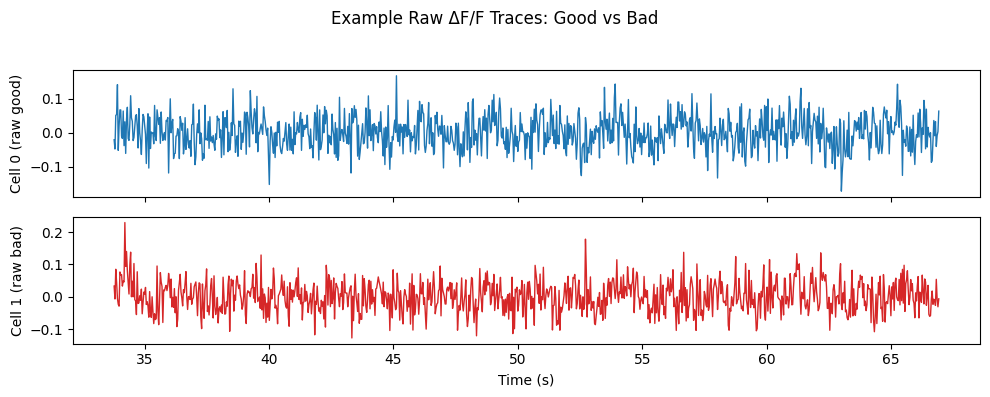

In [10]:
# QC — Example Raw ΔF/F Traces: “Good” vs. “Bad” (pre‑clean)

# recompute thresholds in case this cell is run independently
var_thr_raw = np.percentile(data["var_raw"], 10)
snr_thr_raw = np.percentile(data["snr_raw"], 10)

n_cells = data["dff"].shape[0]
raw_good = np.where((data["var_raw"] > var_thr_raw) & (data["snr_raw"] > snr_thr_raw))[
    0
]
raw_bad = np.setdiff1d(np.arange(n_cells), raw_good)

# pick one example of each
cg, cb = raw_good[0], raw_bad[0]

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax[0].plot(data["t_sparse"][:1000], data["dff_sparse"][cg, :1000], lw=1)
ax[0].set_ylabel(f"Cell {cg} (raw good)")
ax[1].plot(data["t_sparse"][:1000], data["dff_sparse"][cb, :1000], lw=1, color="C3")
ax[1].set_ylabel(f"Cell {cb} (raw bad)")
ax[1].set_xlabel("Time (s)")
plt.suptitle("Example Raw ΔF/F Traces: Good vs Bad")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [11]:
# QC: fraction of session that is sparse-noise
frac = data["mask_sparse"].mean()
print(f"Fraction of session in sparse-noise epochs: {frac:.3f} ({frac*100:.1f}%)")

Fraction of session in sparse-noise epochs: 0.632 (63.2%)


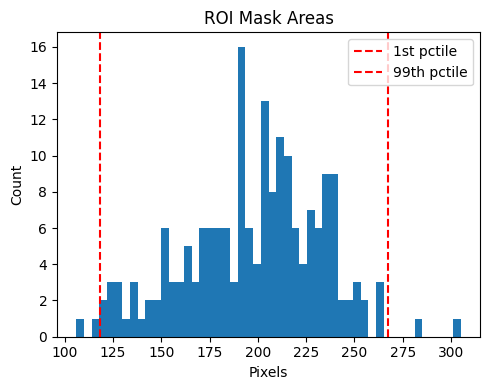

In [12]:
# QC — ROI‑Mask Area Distribution
areas = np.array([mask.sum() for mask in data["roi_masks"]])
p1 = np.percentile(areas, 1)
p99 = np.percentile(areas, 99)

plt.figure(figsize=(5, 4))
plt.hist(areas, bins=50)
plt.axvline(p1, color="r", linestyle="--", label="1st pctile")
plt.axvline(p99, color="r", linestyle="--", label="99th pctile")
plt.title("ROI Mask Areas")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

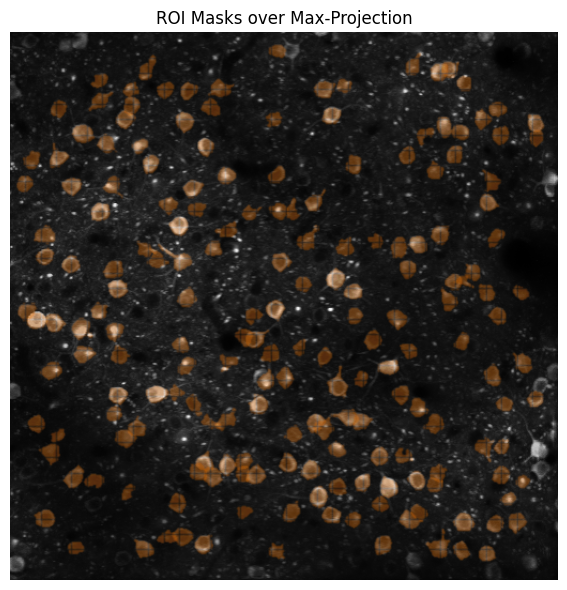

In [13]:
# QC — Overlay All ROI Masks on Max‑Projection
plt.figure(figsize=(6, 6))
plt.imshow(data["max_projection"], cmap="gray")
for i in range(data["roi_masks"].shape[0]):
    ys, xs = np.nonzero(data["roi_masks"][i])
    plt.scatter(xs, ys, s=1, alpha=0.05, color="C1")
plt.title("ROI Masks over Max‑Projection")
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
# QC — Unique Epoch Names
epochs = data["stim_epoch_table"]
first = epochs[0]
name_col = next(i for i, x in enumerate(first) if isinstance(x, str))
names = epochs[:, name_col].astype(str)

print("Unique epoch names:\n", np.unique(names))

Unique epoch names:
 ['locally_sparse_noise' 'natural_movie_one' 'natural_movie_two'
 'spontaneous']


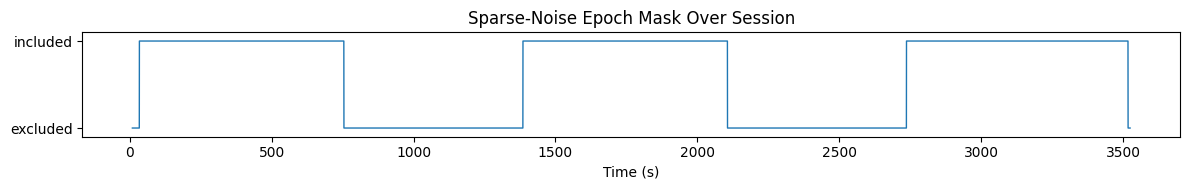

In [15]:
# QC — Sparse‑Noise Epoch Mask Timeline
plt.figure(figsize=(12, 2))
plt.plot(data["t"], data["mask_sparse"], lw=1)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ["excluded", "included"])
plt.xlabel("Time (s)")
plt.title("Sparse‑Noise Epoch Mask Over Session")
plt.tight_layout()
plt.show()

In [16]:
from utils import isolate_sparse_epochs

# isolate only the locally_sparse_noise blocks
mask = isolate_sparse_epochs(data, target="locally_sparse_noise", offset=0)
print("Frames in ‘locally_sparse_noise’:", mask.sum())

Frames in ‘locally_sparse_noise’: 66981


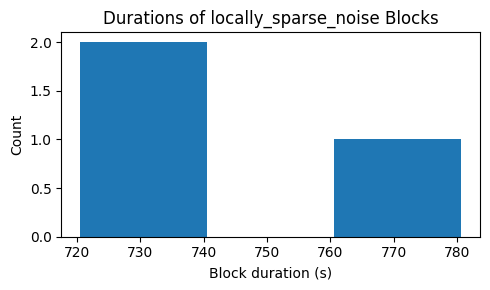

Mean block duration: 740.6s, n blocks = 3


In [17]:
# QC — Durations of locally_sparse_noise Blocks
idx = np.where(np.diff(data["mask_sparse"].astype(int)) != 0)[0] + 1
starts = idx[0::2]
ends = idx[1::2]
dts = np.median(np.diff(data["t"]))
durs = (ends - starts) * dts

plt.figure(figsize=(5, 3))
plt.hist(durs, bins=len(durs))
plt.xlabel("Block duration (s)")
plt.ylabel("Count")
plt.title("Durations of locally_sparse_noise Blocks")
plt.tight_layout()
plt.show()

print(f"Mean block duration: {durs.mean():.1f}s, n blocks = {len(durs)}")

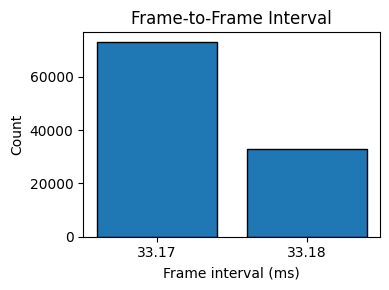

Frame intervals:
  33.17 ms → 73011 frames
  33.18 ms → 32956 frames
Median = 33.170 ms


In [18]:
# QC — Frame‑to‑Frame Interval Distribution (ms)
import numpy as np
import matplotlib.pyplot as plt

# 1) compute intervals in ms and round to two decimals
dts_ms = np.round(np.diff(data["t"]) * 1e3, 2)

# 2) get the two unique values and their counts
uni, counts = np.unique(dts_ms, return_counts=True)

# 3) bar‑plot with a small width so they sit side by side
fig, ax = plt.subplots(figsize=(4, 3))
bar_width = (uni[1] - uni[0]) * 0.8  # 80% of the gap
ax.bar(uni, counts, width=bar_width, edgecolor="k", color="C0")

# 4) tidy up axes
ax.set_xticks(uni)
ax.set_xticklabels([f"{u:.2f}" for u in uni])
ax.set_xlabel("Frame interval (ms)")
ax.set_ylabel("Count")
ax.set_title("Frame‑to‑Frame Interval")

plt.tight_layout()
plt.show()

# 5) print a concise summary
print(
    f"Frame intervals:\n"
    f"  {uni[0]:.2f} ms → {counts[0]} frames\n"
    f"  {uni[1]:.2f} ms → {counts[1]} frames\n"
    f"Median = {np.median(dts_ms):.3f} ms"
)

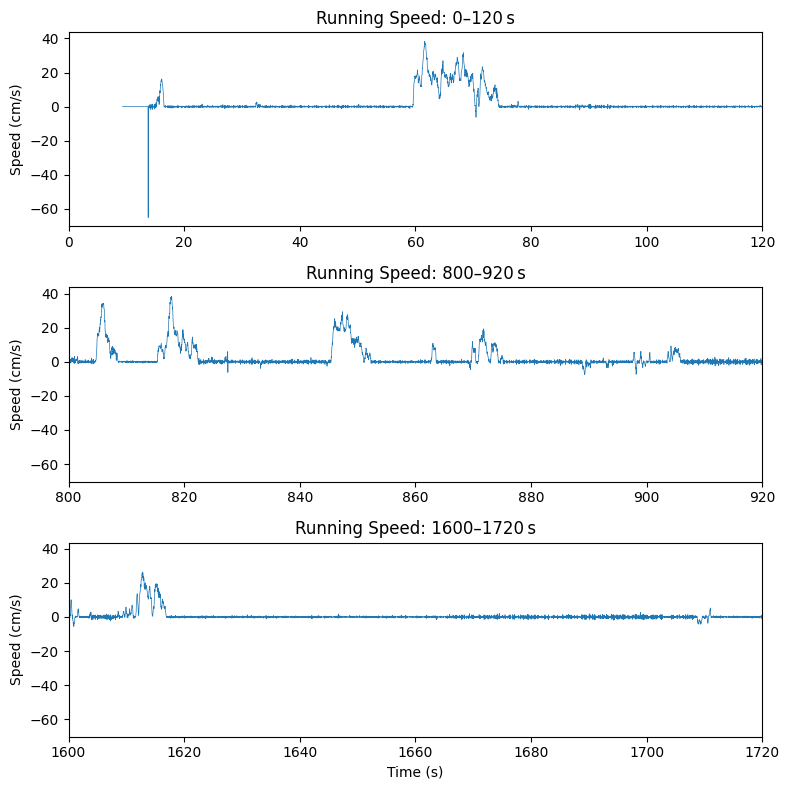

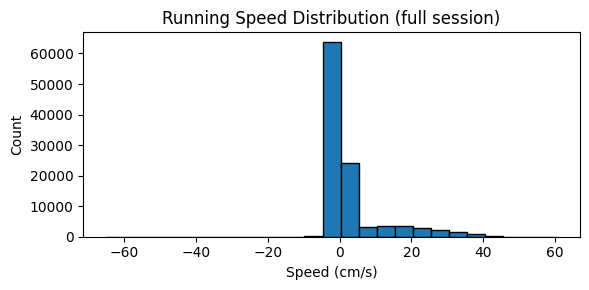

Speed stats — min: -65.1 cm/s, max: 60.6 cm/s, median: 0.1 cm/s


In [19]:
# QC — Running Speed Snippets Across Session

# retrieve cleaned time & speed
run_t = data["run_t"]
run_speed = data["run_speed"]

# define three 2‑minute windows (in seconds)
windows = [0, 800, 1600]

fig, axs = plt.subplots(len(windows), 1, figsize=(8, 8), sharey=True)

for ax, start in zip(axs, windows):
    # mask for 120‑s snippet
    mask = (run_t >= start) & (run_t < start + 120)
    ax.plot(run_t[mask], run_speed[mask], lw=0.5)
    ax.set_xlim(start, start + 120)
    ax.set_ylabel("Speed (cm/s)")
    ax.set_title(f"Running Speed: {start}–{start+120} s")

# label only the bottom axis
axs[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

# 3) histogram of full‐session speed
plt.figure(figsize=(6, 3))
plt.hist(run_speed, bins=25, edgecolor="k")
plt.xlabel("Speed (cm/s)")
plt.ylabel("Count")
plt.title("Running Speed Distribution (full session)")
plt.tight_layout()
plt.show()

# 4) concise printed stats
print(
    f"Speed stats — min: {run_speed.min():.1f} cm/s, "
    f"max: {run_speed.max():.1f} cm/s, "
    f"median: {np.median(run_speed):.1f} cm/s"
)

# 2 Neuropil Subtraction

## 2.1 Neuropil Estimation & Robust Regression (Huber) & Clamp ρ

In [20]:
# Step Neuropil Estimation & Robust Regression

from utils import estimate_neuropil_proxy, regress_neuropil_robust

# Grab all sparse‐noise ΔF/F traces
dff_sparse_all = data["dff_sparse"]  # shape: (n_cells, n_time)

# Estimate neuropil proxy (mean of other cells)
neuropil_proxy = estimate_neuropil_proxy(dff_sparse_all)

# Perform robust per‐cell regression & clamp ρ to [0.5, 0.9]
dff_regressed, rho_neuropil = regress_neuropil_robust(
    dff_sparse_all, neuropil_proxy, clamp=(0.0, 0.9)
)

# Store results for downstream steps
data.update(
    {
        "neuropil_proxy": neuropil_proxy,
        "dff_regressed": dff_regressed,
        "rho_neuropil": rho_neuropil,
    }
)

# 5) Quick sanity check
print(f"Neuropil regression done for {dff_regressed.shape[0]} cells.")
print("Example ρ values (first 5 cells):", rho_neuropil[:5])

Neuropil regression done for 189 cells.
Example ρ values (first 5 cells): [0.17324905 0.2983702  0.42147005 0.26641281 0.34971622]


## 2.2 QC of Neuropil Regression

### 2.2.1 ρ Distribution

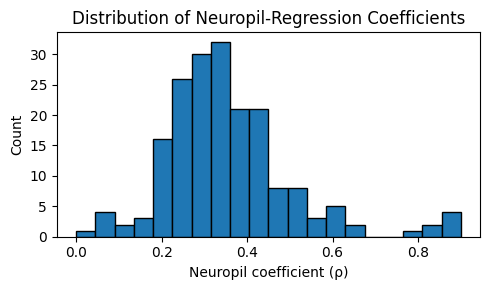

Min ρ = 0.00,  Max ρ = 0.90,  Median ρ = 0.34


In [21]:
# Histogram of ρ values
rho = data["rho_neuropil"]
plt.figure(figsize=(5, 3))
plt.hist(rho, bins=20, edgecolor="k")
plt.xlabel("Neuropil coefficient (ρ)")
plt.ylabel("Count")
plt.title("Distribution of Neuropil‐Regression Coefficients")
plt.tight_layout()
plt.show()

print(
    f"Min ρ = {rho.min():.2f},  Max ρ = {rho.max():.2f},  Median ρ = {np.median(rho):.2f}"
)

### 2.2.2 Example Raw vs Neuropil vs Cleaned Traces

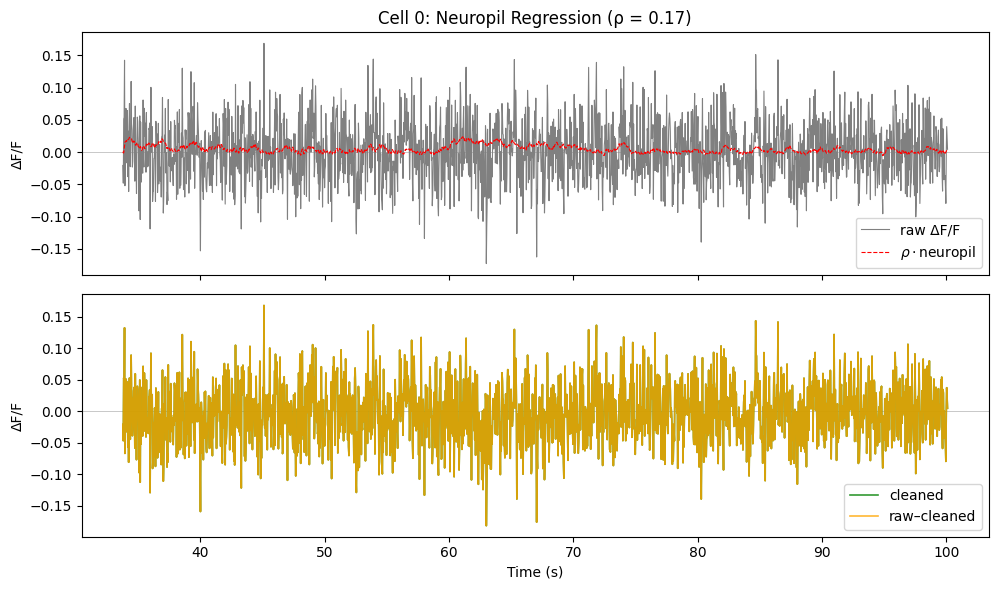

In [22]:
# pick a “good” cell to inspect
cell = data["good_cells"][0]

# pull out the first 2000 sparse‐noise frames
t0 = data["t_sparse"][:2000]
raw0 = data["dff_sparse"][cell, :2000]
np0 = data["neuropil_proxy"][cell, :2000]
rho0 = data["rho_neuropil"][cell]
clean = data["dff_regressed"][cell, :2000]
resid = raw0 - rho0 * np0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# 1) zero baseline lines
for ax in (ax1, ax2):
    ax.axhline(0, color="k", lw=0.5, alpha=0.3)

# 2) Top panel: raw vs. scaled neuropil
ax1.plot(t0, raw0, lw=0.8, color="gray", label="raw ΔF/F")
ax1.plot(
    t0, rho0 * np0, lw=0.8, color="red", linestyle="--", label=r"$\rho\cdot$neuropil"
)
ax1.set_ylabel("ΔF/F")
ax1.set_title(f"Cell {cell}: Neuropil Regression (ρ = {rho0:.2f})")
ax1.legend(loc="lower right")

# 3) Bottom panel: cleaned vs. raw–cleaned residual
ax2.plot(t0, clean, lw=1.2, alpha=0.8, color="green", label="cleaned")
ax2.plot(t0, resid, lw=1.2, alpha=0.8, color="orange", label="raw–cleaned")
ax2.set_ylabel("ΔF/F")
ax2.set_xlabel("Time (s)")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

# 3. Baseline Correction & Denoising

## 3.1 Drift Removal (60 s 10th‑percentile)

In [23]:
# Drift Removal via Sliding‐Window Percentile Baseline
from utils import sliding_baseline

# inputs: neuropil‐regressed ΔF/F and its timebase
dff_in = data["dff_regressed"]  # shape: (n_cells, n_time)
tvec = data["t_sparse"]  # shape: (n_time,)

# compute & subtract 10th‐percentile baseline over 60 s windows
baseline, dff_drift, win_frames = sliding_baseline(
    dff_in,
    tvec,
    window_sec=60,  # window length in seconds
    pct=10,  # percentile for baseline
    mode="nearest",  # boundary handling
)

# store for downstream steps
data.update(
    {
        "dff_baseline": baseline,
        "dff_drift": dff_drift,
        "drift_win": win_frames,
    }
)

# report
dt = np.median(np.diff(tvec))
print(f"Drift‐window: {win_frames} frames (~{win_frames*dt:.1f} s)")

Drift‐window: 1809 frames (~60.0 s)


## 3.2 QC of Drift Removal

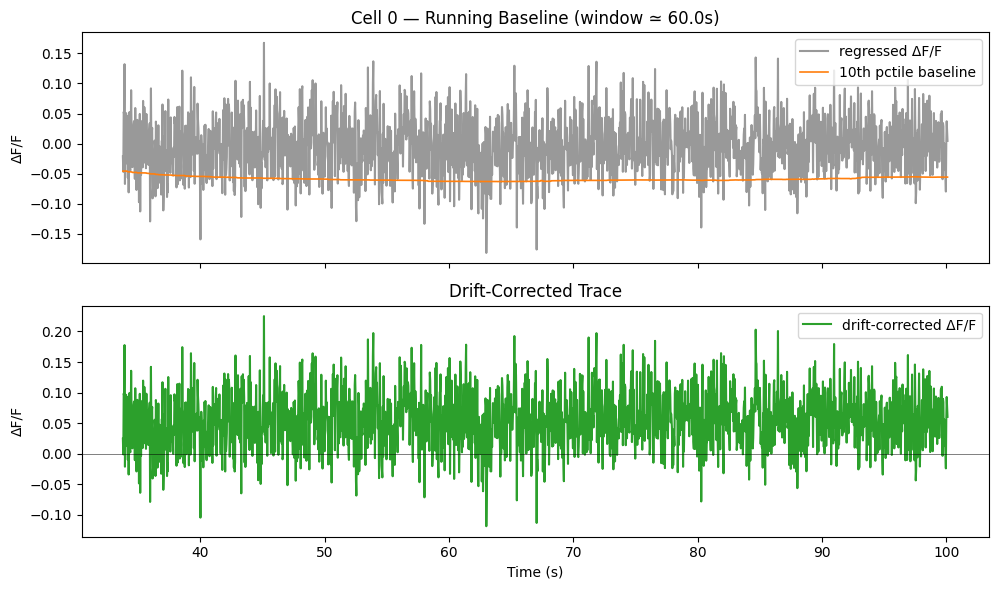

In [24]:
# Plot Baseline & Drift‐Corrected for One Example Cell

# pick a “good” cell for visualization
cell = data["good_cells"][0]
t0 = data["t_sparse"][:2000]
raw = data["dff_regressed"][cell, :2000]
bl = data["dff_baseline"][cell, :2000]
corr = data["dff_drift"][cell, :2000]

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# top: raw & running baseline
ax[0].plot(t0, raw, color="gray", label="regressed ΔF/F", alpha=0.8)
ax[0].plot(t0, bl, color="C1", label=f"{10}th pctile baseline", lw=1.2)
ax[0].set_ylabel("ΔF/F")
ax[0].set_title(
    f"Cell {cell} — Running Baseline (window ≃ {data['drift_win']*dt:.1f}s)"
)
ax[0].legend(loc="upper right")

# bottom: drift‐removed trace
ax[1].plot(t0, corr, color="C2", label="drift‑corrected ΔF/F")
ax[1].axhline(0, color="k", lw=0.5, alpha=0.7)
ax[1].set_ylabel("ΔF/F")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Drift‑Corrected Trace")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## 3.3 Savitzky–Golay Smoothing (w=11, p=2)

In [25]:
# Savitzky–Golay Smoothing
from utils import smooth_dff_savgol

sg_window = 11  # frames
sg_poly = 2  # polynomial order

# pull the drift‑corrected traces
dff_dc = data["dff_drift"]  # shape (n_cells, n_time)

# smooth them
dff_smooth = smooth_dff_savgol(dff_dc, window=sg_window, polyorder=sg_poly)

# store back
data["dff_smooth"] = dff_smooth

print(f"Savitzky–Golay smoothing → window={sg_window}, polyorder={sg_poly}")
print("Smoothed shape:", dff_smooth.shape)

Savitzky–Golay smoothing → window=11, polyorder=2
Smoothed shape: (189, 66981)


## 3.4 QC of Smoothed Traces

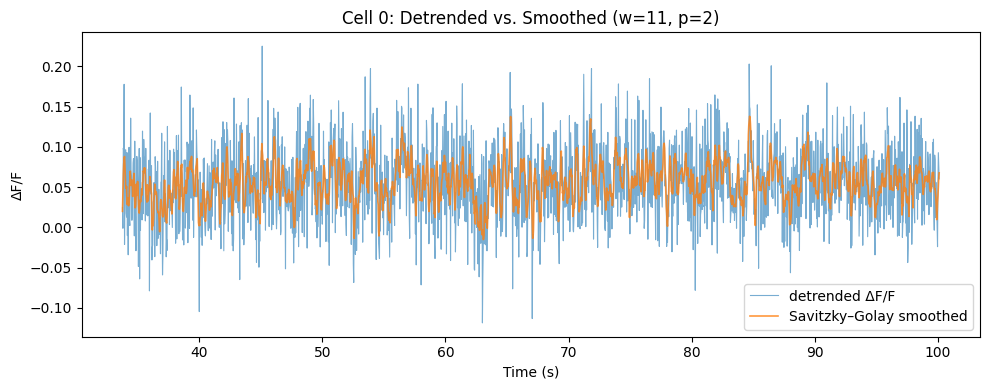

In [26]:
# QC: Example Raw vs. Smoothed Trace

cell = data["good_cells"][0]
t0 = data["t_sparse"][:2000]

raw0 = dff_dc[cell, :2000]
smooth0 = data["dff_smooth"][cell, :2000]

plt.figure(figsize=(10, 4))
plt.plot(t0, raw0, lw=0.8, alpha=0.6, label="detrended ΔF/F")
plt.plot(t0, smooth0, lw=1.2, alpha=0.8, label="Savitzky–Golay smoothed")
plt.xlabel("Time (s)")
plt.ylabel("ΔF/F")
plt.title(f"Cell {cell}: Detrended vs. Smoothed (w={sg_window}, p={sg_poly})")
plt.legend()
plt.tight_layout()
plt.show()

# 5 Final QC on Cleaned Data

## 5.1 Compute Clean ΔF/F QC Metrics

In [27]:
# QC on Final Cleaned ΔF/F
from utils import compute_qc_metrics


# 1) Pull in your final cleaned traces
dff_clean = data["dff_smooth"]  # shape (n_cells, n_time)

# 2) Compute per‑cell variance & S NR
var_clean, snr_clean = compute_qc_metrics(dff_clean)

# 3) Compute 10th‐percentile thresholds
var_thr_clean = np.percentile(var_clean, 10)
snr_thr_clean = np.percentile(snr_clean, 10)

# 4) Store them for downstream
data.update(
    {
        "var_clean": var_clean,
        "snr_clean": snr_clean,
        "var_thr_clean": var_thr_clean,
        "snr_thr_clean": snr_thr_clean,
    }
)

# 5) Quick summary
n_pass = np.sum((var_clean > var_thr_clean) & (snr_clean > snr_thr_clean))
print(f"Cleaned ΔF/F QC thresholds: var>{var_thr_clean:.3f}, snr>{snr_thr_clean:.3f}")
print(f"Cells passing cleaned‐QC: {n_pass}/{len(var_clean)}")

Cleaned ΔF/F QC thresholds: var>0.001, snr>1.770
Cells passing cleaned‐QC: 151/189


## 5.2 Compare Raw vs Clean Variance & SNR Distributions

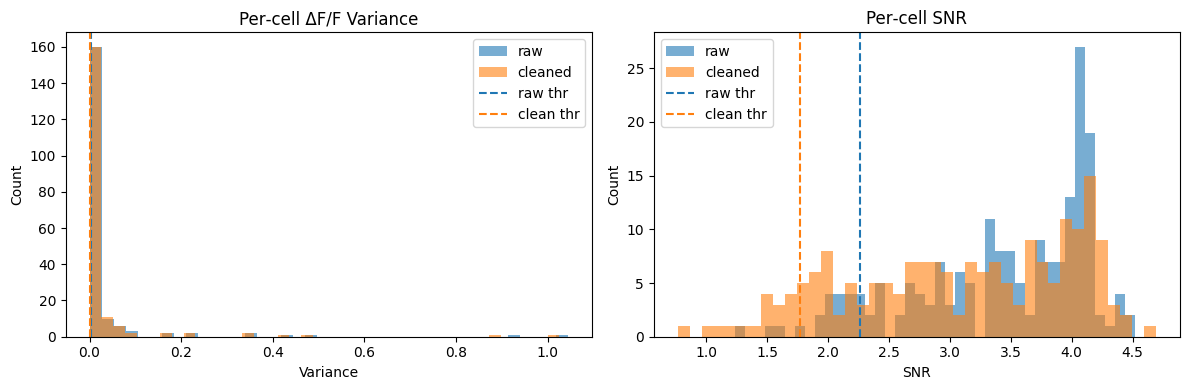

In [28]:
# Histograms: raw vs. cleaned variance & SNR
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Variance
axs[0].hist(data["var_raw"], bins=40, alpha=0.6, label="raw")
axs[0].hist(data["var_clean"], bins=40, alpha=0.6, label="cleaned")
axs[0].axvline(data["var_thr_raw"], color="C0", linestyle="--", label="raw thr")
axs[0].axvline(data["var_thr_clean"], color="C1", linestyle="--", label="clean thr")
axs[0].set_title("Per‑cell ΔF/F Variance")
axs[0].set_xlabel("Variance")
axs[0].set_ylabel("Count")
axs[0].legend()

# SNR
axs[1].hist(data["snr_raw"], bins=40, alpha=0.6, label="raw")
axs[1].hist(data["snr_clean"], bins=40, alpha=0.6, label="cleaned")
axs[1].axvline(data["snr_thr_raw"], color="C0", linestyle="--", label="raw thr")
axs[1].axvline(data["snr_thr_clean"], color="C1", linestyle="--", label="clean thr")
axs[1].set_title("Per‑cell SNR")
axs[1].set_xlabel("SNR")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()
plt.show()

## 5.3 Full‐Pipeline Trace Overlay

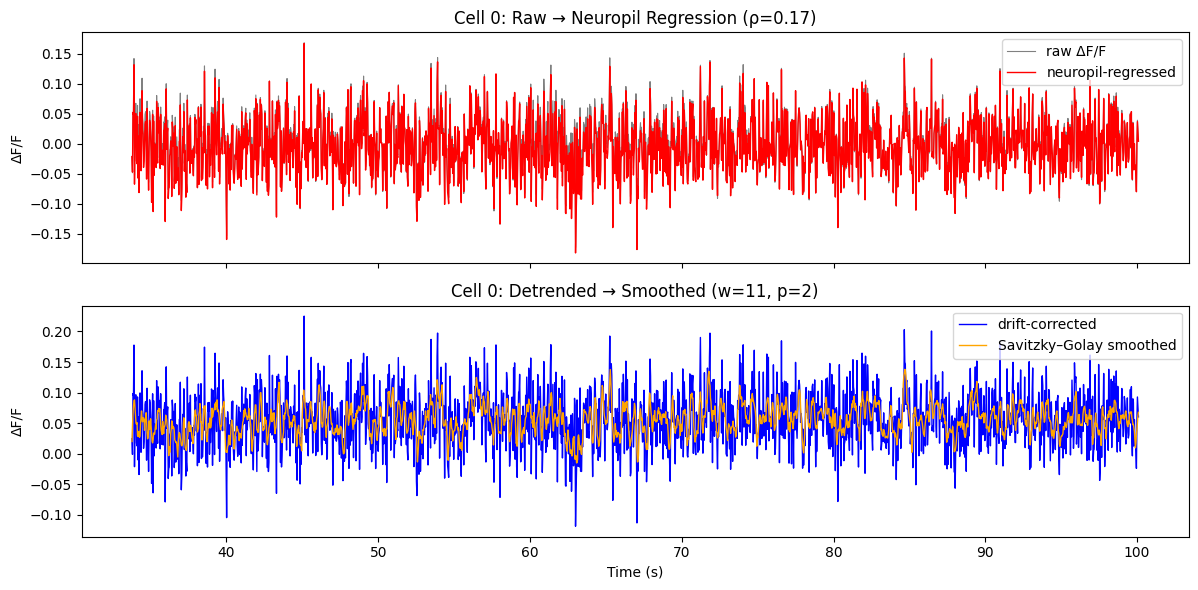

In [29]:
# QC — Full Cleaning Pipeline Overlay (first 2 000 frames)


# pick one good cell for demonstration
cell = data["good_cells"][0]
n0 = 2000  # number of frames

# pull out the four versions of this cell’s trace
t0 = data["t_sparse"][:n0]
raw0 = data["dff_sparse"][cell, :n0]
reg0 = data["dff_regressed"][cell, :n0]
detr0 = data["dff_drift"][cell, :n0]  # drift‑corrected
smooth0 = data["dff_smooth"][cell, :n0]  # Savitzky–Golay smoothed

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# top: raw vs. neuropil‑regressed
ax1.plot(t0, raw0, color="gray", linewidth=0.8, label="raw ΔF/F")
ax1.plot(t0, reg0, color="red", linewidth=1, label="neuropil‑regressed")
ax1.set_ylabel("ΔF/F")
ax1.set_title(
    f"Cell {cell}: Raw → Neuropil Regression (ρ={data['rho_neuropil'][cell]:.2f})"
)
ax1.legend(loc="upper right")

# bottom: drift‑corrected vs. smoothed
ax2.plot(t0, detr0, color="blue", linewidth=1, label="drift‑corrected")
ax2.plot(t0, smooth0, color="orange", linewidth=1, label="Savitzky–Golay smoothed")
ax2.set_ylabel("ΔF/F")
ax2.set_xlabel("Time (s)")
ax2.set_title(f"Cell {cell}: Detrended → Smoothed (w={sg_window}, p={sg_poly})")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

# 6. (Optional) Downsampling for Speed

## 6.1 Decimate to ≃10 Hz

In [29]:
# Downsampling to 10 Hz for Speed
from utils import downsample_traces

# original 30 Hz data (final cleaned)
dff30 = data["dff_smooth"]  # (n_cells, n_time30)
t30 = data["t_sparse"]  # (n_time30,)
target_fs = 10  # 10Hz

# run down‑sampling
dff10, t10, decim_fctr, fs10 = downsample_traces(dff30, t30, target_fs=target_fs)

print(f"Decimated by {decim_fctr}× → {dff10.shape[1]} frames at {fs10:.1f} Hz")

# store
data.update(
    {
        "dff_ds": dff10,
        "t_ds": t10,
        "fs_ds": fs10,
        "decim_fctr": decim_fctr,
    }
)

Decimated by 3× → 22327 frames at 10.0 Hz


In [30]:
# compare one cell’s full‑rate vs 10 Hz variance
np.var(data["dff_smooth"][cell]), np.var(data["dff_ds"][cell])

(0.0025461572, 0.0025263152)

data

### Data Dictionary Keys Reference

1. **Raw & Epoched Data**  
   - `dff_sparse`   : ΔF/F traces (n_cells × n_time) in sparse‐noise epochs  
   - `t_sparse`     : time vector (n_time) for sparse‐noise epochs  
   - `mask_sparse`  : boolean mask (n_time) of sparse‐noise frames  

2. **Raw QC Metrics & Splits**  
   - `var_raw`      : per‐cell variance on `dff_sparse`  
   - `snr_raw`      : per‐cell SNR on `dff_sparse`  
   - `var_thr_raw`  : 10th‑percentile variance threshold  
   - `snr_thr_raw`  : 10th‑percentile SNR threshold  
   - `good_cells`   : indices of cells passing raw QC  
   - `bad_cells`    : indices of cells failing raw QC  

3. **Neuropil Subtraction**  
   - `neuropil_proxy`  : estimated neuropil ΔF/F (n_cells × n_time)  
   - `rho_neuropil`    : per‑cell contamination coefficients  
   - `dff_regressed`   : neuropil‐subtracted ΔF/F  

4. **Drift Removal**  
   - `dff_baseline`  : 60 s running‐percentile baseline  
   - `dff_drift`     : drift‑corrected traces (`dff_regressed - baseline`)  
   - `drift_win`     : window length in frames  

5. **Smoothing**  
   - `dff_smooth`    : Savitzky–Golay smoothed traces  

6. **Clean QC Metrics**  
   - `var_clean`     : per‐cell variance on `dff_smooth`  
   - `snr_clean`     : per‐cell SNR on `dff_smooth`  
   - `var_thr_clean` : 10th‑percentile variance threshold (cleaned)  
   - `snr_thr_clean` : 10th‑percentile SNR threshold (cleaned)  

7. **Downsampled (Optional)**  
   - `dff_ds`        : downsampled traces (e.g. ~10 Hz)  
   - `t_ds`          : downsampled time vector  
   - `fs_ds`         : actual downsampled sampling rate  
   - `decim_fctr`    : integer decimation factor  


## 6. Spike Inference & Hyperparameter Sweeps

## 6.1 Estimate per‑cell noise for deconvolution

In [30]:
# Noise Estimation
from utils import estimate_noise_sigma

dff_for_noise = data["dff_smooth"]
dt = np.median(np.diff(data["t_sparse"]))
print(f"dt = {dt:.5f} s (≈{1.0/dt:.1f} Hz)")

# per‑frame σ (OASIS expects noise per sample)
noise_sigma = estimate_noise_sigma(dff_for_noise)
data.update({"noise_sigma": noise_sigma, "noise_dt": dt})

print("Estimated noise_sigma for each cell:")
print(noise_sigma[:5])

dt = 0.03317 s (≈30.1 Hz)
Estimated noise_sigma for each cell:
[0.00790449 0.00743161 0.00830615 0.00931993 0.00912261]


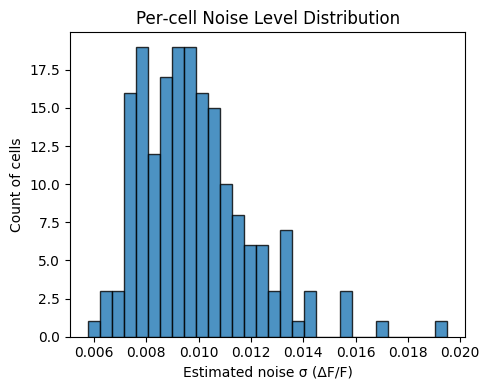

In [31]:
# QC — Distribution of Estimated Noise σ

sigma = data["noise_sigma"]

plt.figure(figsize=(5, 4))
plt.hist(sigma, bins=30, edgecolor="k", alpha=0.8)
plt.xlabel("Estimated noise σ (ΔF/F)")
plt.ylabel("Count of cells")
plt.title("Per‑cell Noise Level Distribution")
plt.tight_layout()
plt.show()

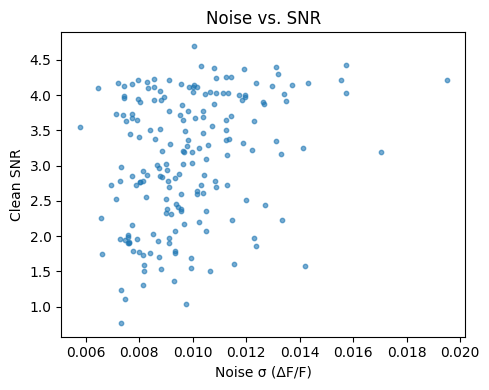

In [32]:
# QC — Noise vs. SNR
plt.figure(figsize=(5, 4))
plt.scatter(data["noise_sigma"], data["snr_clean"], s=10, alpha=0.6)
plt.xlabel("Noise σ (ΔF/F)")
plt.ylabel("Clean SNR")
plt.title("Noise vs. SNR")
plt.tight_layout()
plt.show()

## 6.2 Spike Inference — OASIS Deconvolution

In [33]:
# OASIS Deconvolution (single pass)
from utils import deconvolve_oasis

dff_in = data["dff_smooth"]
dt = data["noise_dt"]
fs = 1.0 / dt

oas_res = deconvolve_oasis(dff=dff_in, fs=fs, penalty=1.0, g_init=None, optimize_g=True)

data.update(
    {
        "oasis_c": oas_res["c"],
        "oasis_s": oas_res["s"],
        "oasis_b": oas_res["b"],
        "oasis_g": oas_res["g"],
        "oasis_fs": fs,
    }
)

total_time = dff_in.shape[1] * dt
event_rate = oas_res["s"].sum(axis=1) / total_time
data["oasis_rate"] = event_rate

print("OASIS deconvolution complete")
print("Example AR(1) g:", np.round(oas_res["g"][:5], 3))
print("Example rates (Hz):", np.round(event_rate[:5], 3))

OASIS deconvolution complete
Example AR(1) g: [0.893 0.802 0.836 0.866 0.803]
Example rates (Hz): [0.007 0.255 0.234 0.236 0.322]


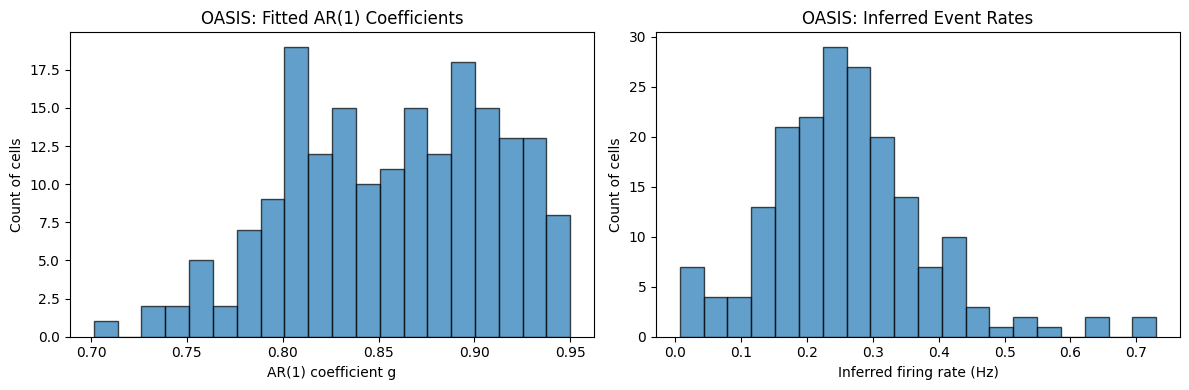

In [35]:
# QC — AR(1) coefficients & event‐rate distributions

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# AR(1) g
axs[0].hist(data["oasis_g"], bins=20, edgecolor="k", alpha=0.7)
axs[0].set_xlabel("AR(1) coefficient g")
axs[0].set_ylabel("Count of cells")
axs[0].set_title("OASIS: Fitted AR(1) Coefficients")

# Event rates
axs[1].hist(data["oasis_rate"], bins=20, edgecolor="k", alpha=0.7)
axs[1].set_xlabel("Inferred firing rate (Hz)")
axs[1].set_ylabel("Count of cells")
axs[1].set_title("OASIS: Inferred Event Rates")

plt.tight_layout()
plt.show()

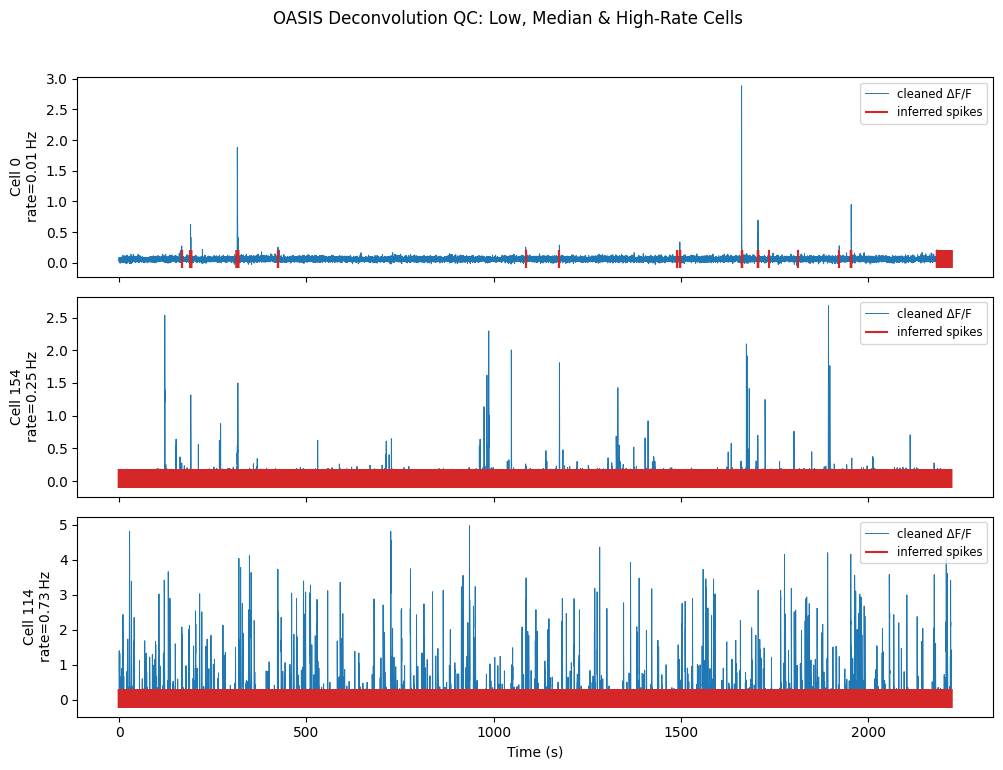

In [36]:
# Select a few cells spanning low→high rate
rates = data["oasis_rate"]
cells = np.argsort(rates)[[0, len(rates) // 2, -1]]  # min, median, max rate
t = np.arange(data["dff_smooth"].shape[1]) * data["noise_dt"]
dff = data["dff_smooth"]
s = data["oasis_s"]

fig, axes = plt.subplots(len(cells), 1, figsize=(10, 2.5 * len(cells)), sharex=True)
for ax, ci in zip(axes, cells):
    ax.plot(t, dff[ci], color="C0", lw=0.7, label="cleaned ΔF/F")
    spike_times = t[s[ci] > 0]
    ax.vlines(
        spike_times,
        ymin=min(dff[ci]),
        ymax=min(dff[ci]) + 0.1 * (max(dff[ci]) - min(dff[ci])),
        color="C3",
        lw=1.5,
        label="inferred spikes",
    )
    ax.set_ylabel(f"Cell {ci}\nrate={rates[ci]:.2f} Hz")
    ax.legend(loc="upper right", fontsize="small")
axes[-1].set_xlabel("Time (s)")
plt.suptitle("OASIS Deconvolution QC: Low, Median & High‐Rate Cells", y=1.02)
plt.tight_layout()
plt.show()

## 6.3 Compute Reconstruction & Fit Metrics

In [37]:
# Fit‑Quality Scoring
from sklearn.metrics import r2_score
from utils import reconvolve_calcium_kernel

s_hat = data["oasis_s"]
g_hat = data["oasis_g"]
b_hat = data["oasis_b"]
y_clean = data["dff_smooth"]
dt = data["noise_dt"]
n_cells, n_t = s_hat.shape

# reconstruct via AR(1)
y_rec = np.zeros_like(y_clean)
for i in range(n_cells):
    y_rec[i] = reconvolve_calcium_kernel(s_hat[i], g_hat[i], b_hat[i])

# compute metrics
ss_res = np.sum((y_clean - y_rec) ** 2, axis=1)
ss_tot = np.sum((y_clean - y_clean.mean(axis=1, keepdims=True)) ** 2, axis=1)
r2 = 1 - ss_res / ss_tot
mse = ss_res / n_t

event_counts = s_hat.sum(axis=1)
rates_hz = event_counts / (n_t * dt)

fit_qc = pd.DataFrame(
    {
        "r2": r2,
        "mse": mse,
        "event_count": event_counts.astype(int),
        "rate_hz": rates_hz,
        "g_ar1": g_hat,
    },
    index=pd.Index(np.arange(n_cells), name="cell"),
)

data["fit_qc"] = fit_qc
print(f"Computed fit metrics for {n_cells} cells.")
display(fit_qc.head())

Computed fit metrics for 189 cells.


,r2,mse,event_count,rate_hz,g_ar1
cell,,,,,
0,0.783574,0.000551,15,0.006882,0.892800
1,0.931517,0.000047,567,0.255221,0.802260
2,0.955564,0.000107,518,0.233503,0.835849
3,0.966648,0.000115,523,0.235576,0.866176
4,0.916316,0.000075,716,0.322445,0.803398


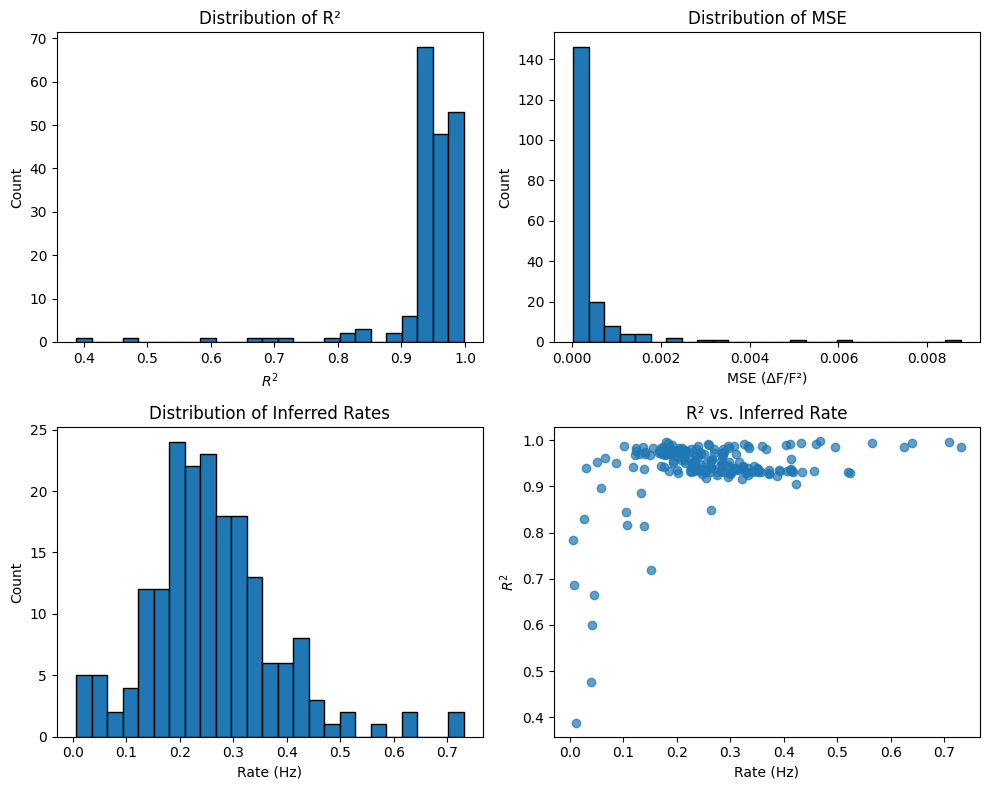

In [38]:
# Visualize Fit‑Quality Distributions
df = data["fit_qc"]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# R² histogram
axs[0, 0].hist(df["r2"], bins=25, edgecolor="k")
axs[0, 0].set_title("Distribution of R²")
axs[0, 0].set_xlabel("$R^2$")
axs[0, 0].set_ylabel("Count")

# MSE histogram
axs[0, 1].hist(df["mse"], bins=25, edgecolor="k")
axs[0, 1].set_title("Distribution of MSE")
axs[0, 1].set_xlabel("MSE (ΔF/F²)")
axs[0, 1].set_ylabel("Count")

# Event‐rate histogram
axs[1, 0].hist(df["rate_hz"], bins=25, edgecolor="k")
axs[1, 0].set_title("Distribution of Inferred Rates")
axs[1, 0].set_xlabel("Rate (Hz)")
axs[1, 0].set_ylabel("Count")

# R² vs. rate scatter
axs[1, 1].scatter(df["rate_hz"], df["r2"], alpha=0.7)
axs[1, 1].set_title("R² vs. Inferred Rate")
axs[1, 1].set_xlabel("Rate (Hz)")
axs[1, 1].set_ylabel("$R^2$")

plt.tight_layout()
plt.show()

## 6.4 Hyperparamter Sweeps

In [39]:
# Hyperparameter Sweep
from utils import sweep_oasis_params

# random search: N=25 pairs
rng = np.random.default_rng(0)
N_draws = 25
g_rand = rng.uniform(0.6, 0.95, size=N_draws)
lam_rand = np.exp(rng.uniform(np.log(0.1), np.log(3.0), size=N_draws))
params = list(zip(g_rand, lam_rand))

cells_to_test = data["good_cells"][:50]
fs_sweep = 1.0 / np.median(np.diff(data["t_sparse"]))

results_df = sweep_oasis_params(
    dff_clean=data["dff_smooth"],
    fs=fs_sweep,
    noise_sigma=data["noise_sigma"],
    params=params,
    cells=cells_to_test,
    n_jobs=-1,
)

summary = (
    results_df.groupby(["g", "lam"])["r2"]
    .mean()
    .reset_index()
    .sort_values("r2", ascending=False)
)
print("Top 10 parameter combos by avg R²:")
print(summary.head(10))

/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could

Top 10 parameter combos by avg R²:
          g       lam        r2
0  0.600958  0.521961  0.981948
1  0.605785  1.029505  0.981858
2  0.609912  2.065585  0.981780
3  0.611755  2.397152  0.981745
4  0.614341  2.810689  0.981690
5  0.643499  0.216541  0.980871
6  0.661479  0.698584  0.980201
7  0.694425  2.971666  0.978656
8  0.704899  0.315599  0.978066
9  0.747941  0.378851  0.974936


In [69]:
# Final OASIS with per-cell g optimization
from tqdm.notebook import tqdm
from utils import deconvolve_oasis, compute_fit_metrics

dff_clean = data["dff_smooth"]
fs = data["oasis_fs"]  # 1/dt
lam_opt = 0.5220  # from sweep
g_init = 0.6010  # from sweep
n_cells, n_t = dff_clean.shape

# pre-allocate output arrays
c_opt = np.zeros_like(dff_clean)
s_opt = np.zeros_like(dff_clean)
b_opt = np.zeros(n_cells, float)
g_opt = np.zeros(n_cells, float)

print("🔄 Running optimized deconvolution for each cell:")
for i in tqdm(range(n_cells), desc="OASIS per cell"):
    out = deconvolve_oasis(
        dff=dff_clean[i : i + 1, :],  # single-cell slice
        fs=fs,
        penalty=lam_opt,
        g_init=g_init,
        optimize_g=True,
    )
    c_opt[i] = out["c"][0]
    s_opt[i] = out["s"][0]
    b_opt[i] = out["b"][0]
    g_opt[i] = out["g"][0]

# unpack into your data dict
data["oas_c_opt"] = c_opt
data["oas_s_opt"] = s_opt
data["oas_b_opt"] = b_opt
data["oas_g_opt"] = g_opt

# now recompute true fit metrics
r2_opt, mse_opt, event_counts, rate_hz = compute_fit_metrics(
    y_true=dff_clean,
    s_hat=data["oas_s_opt"],
    g_hat=data["oas_g_opt"],
    b_hat=data["oas_b_opt"],
    fs=fs,
)

# update your QC table
data["fit_qc"]["r2"] = r2_opt
data["fit_qc"]["mse"] = mse_opt
data["fit_qc"]["event_count"] = event_counts
data["fit_qc"]["rate_hz"] = rate_hz

print("Recomputed fit metrics on optimized traces.")
display(data["fit_qc"].head())

🔄 Running optimized deconvolution for each cell:


OASIS per cell:   0%|          | 0/189 [00:00<?, ?it/s]

Recomputed fit metrics on optimized traces.


,r2,mse,event_count,rate_hz,g_ar1
cell,,,,,
0,0.990210,0.000025,958,0.431190,0.892800
1,0.961720,0.000026,1042,0.468998,0.802260
2,0.983970,0.000039,1289,0.580171,0.835849
3,0.990251,0.000034,1349,0.607176,0.866176
4,0.947841,0.000047,1242,0.559016,0.803398


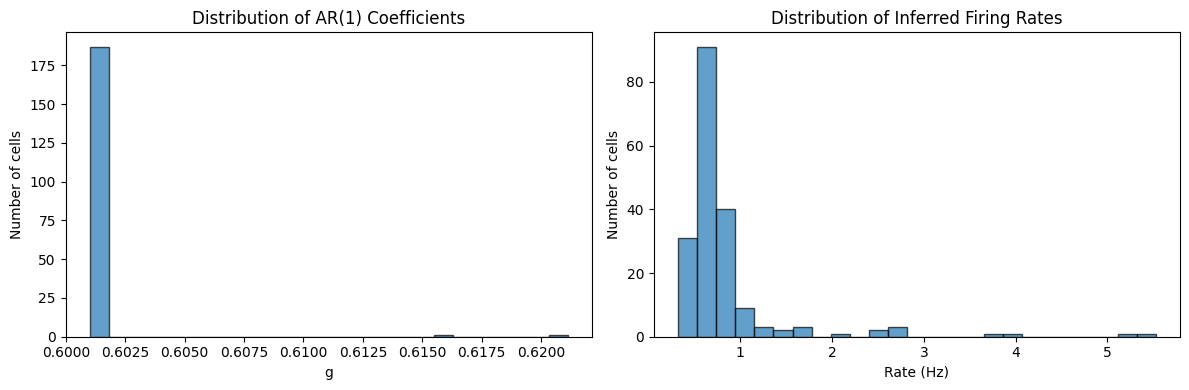

In [70]:
# QC — Coefficients & Firing‐Rate Distributions
g_opt = data["oas_g_opt"]
rates = data["oas_rate_opt"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# AR(1) coefficient histogram
axs[0].hist(g_opt, bins=25, edgecolor="k", alpha=0.7)
axs[0].set_title("Distribution of AR(1) Coefficients")
axs[0].set_xlabel("g")
axs[0].set_ylabel("Number of cells")

# Firing‐rate histogram
axs[1].hist(rates, bins=25, edgecolor="k", alpha=0.7)
axs[1].set_title("Distribution of Inferred Firing Rates")
axs[1].set_xlabel("Rate (Hz)")
axs[1].set_ylabel("Number of cells")

plt.tight_layout()
plt.show()

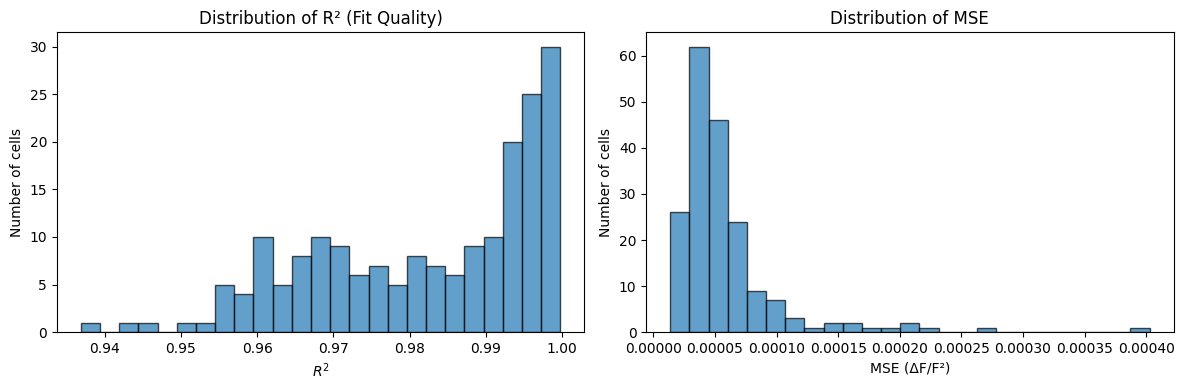

In [71]:
# QC — Fit‑Quality: R² & MSE Distributions
import matplotlib.pyplot as plt

r2 = data["oas_r2_opt"]
mse = data["oas_mse_opt"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# R² histogram
axs[0].hist(r2, bins=25, edgecolor="k", alpha=0.7)
axs[0].set_title("Distribution of R² (Fit Quality)")
axs[0].set_xlabel("$R^2$")
axs[0].set_ylabel("Number of cells")

# MSE histogram
axs[1].hist(mse, bins=25, edgecolor="k", alpha=0.7)
axs[1].set_title("Distribution of MSE")
axs[1].set_xlabel("MSE (ΔF/F²)")
axs[1].set_ylabel("Number of cells")

plt.tight_layout()
plt.show()

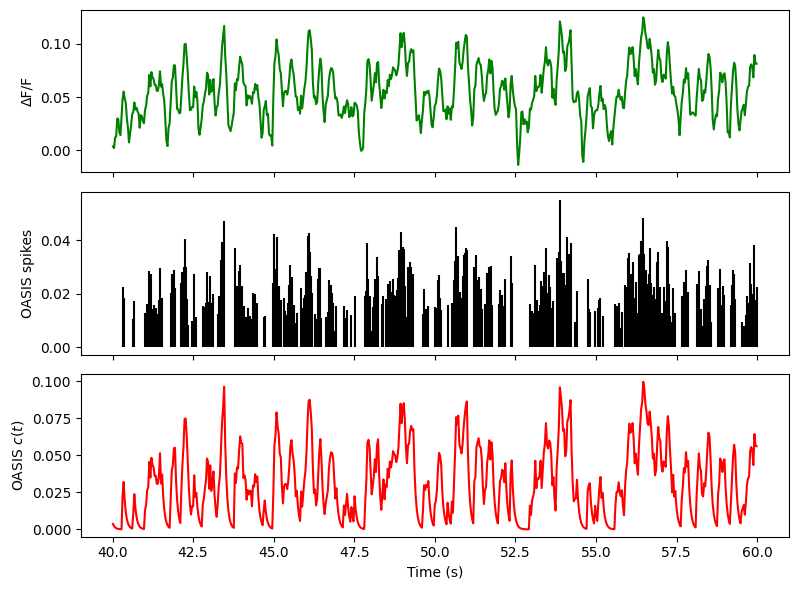

In [72]:
import matplotlib.pyplot as plt

d = data
cell = int(d["good_cells"][0])

# pick absolute window from 40 s to 60 s (within 33.78–3517 s)
t0, t1 = 40.0, 60.0

t = d["t_sparse"]
y = d["dff_smooth"][cell, :]
s = d["oas_s_opt"][cell, :]
c = d["oas_c_opt"][cell, :]

mask = (t >= t0) & (t <= t1)
t_win = t[mask]
y_win = y[mask]
s_win = s[mask]
c_win = c[mask]

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax0.plot(t_win, y_win, color="green")
ax0.set_ylabel("ΔF/F")
ax1.vlines(t_win[s_win > 0], 0, s_win[s_win > 0], color="black")
ax1.set_ylabel("OASIS spikes")
ax2.plot(t_win, c_win, color="red")
ax2.set_ylabel("OASIS $c(t)$")
ax2.set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

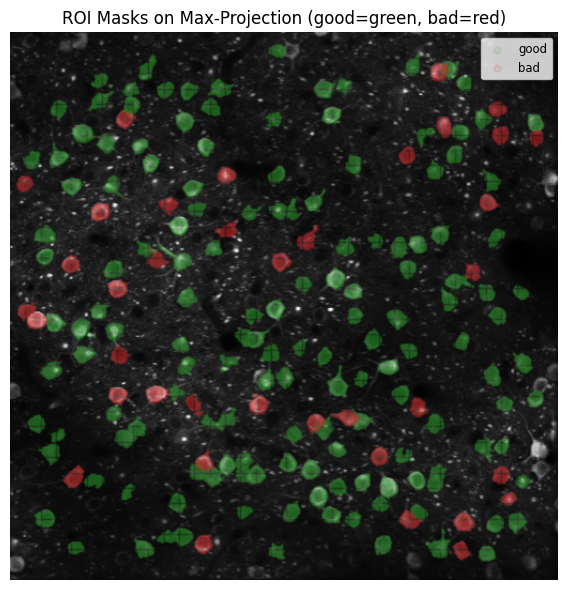

In [73]:
# QC — ROI Masks overlaid on Max‑Projection
max_proj = data["max_projection"]
masks = data["roi_masks"]
good = set(data["good_cells"])
bad = set(data["bad_cells"])

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(max_proj, cmap="gray")
# plot good cells in green, bad in red
for cell_set, color in [(good, "C2"), (bad, "C3")]:
    ys, xs = np.nonzero(np.sum(masks[list(cell_set)], axis=0))
    ax.scatter(
        xs, ys, s=1, alpha=0.1, color=color, label=("good" if color == "C2" else "bad")
    )
ax.set_title("ROI Masks on Max‑Projection (good=green, bad=red)")
ax.axis("off")
ax.legend(markerscale=5, fontsize="small")
plt.tight_layout()
plt.show()

(189, 66981)

# 7. Receptive-Field Mapping & Cross-Validation

In [74]:
data["dff_smooth"].shape

(189, 66981)

In [75]:
# Prepare a dict of only numpy‐serializable objects
save_dict = {}
for key, val in data.items():
    if isinstance(val, np.ndarray):
        save_dict[key] = val
    elif isinstance(val, pd.DataFrame):
        # Convert DataFrame to a structured array for saving
        rec = val.reset_index().to_records(index=False)
        save_dict["fit_qc_records"] = rec

# Save everything as a compressed .npz
out_path = "data/preprocessed/data_snapshot.npz"
np.savez_compressed(out_path, **save_dict)

print(f"Saved data snapshot to {out_path} with keys: {list(save_dict.keys())}")

Saved data snapshot to data/preprocessed/data_snapshot.npz with keys: ['dff', 't', 'stim', 'stim_table', 'stim_epoch_table', 'roi_masks', 'max_projection', 'running_speed', 'mask_sparse', 'dff_sparse', 't_sparse', 'var_raw', 'snr_raw', 'run_t', 'run_speed', 'good_cells', 'bad_cells', 'neuropil_proxy', 'dff_regressed', 'rho_neuropil', 'dff_baseline', 'dff_drift', 'dff_smooth', 'var_clean', 'snr_clean', 'noise_sigma', 'oasis_c', 'oasis_s', 'oasis_b', 'oasis_g', 'oasis_rate', 'fit_qc_records', 'oas_c_opt', 'oas_s_opt', 'oas_b_opt', 'oas_g_opt', 'oas_rate_opt', 'oas_r2_opt', 'oas_mse_opt']


In [77]:
data.keys()

dict_keys(['dff', 't', 'stim', 'stim_table', 'stim_epoch_table', 'roi_masks', 'max_projection', 'running_speed', 'mask_sparse', 'dff_sparse', 't_sparse', 'var_raw', 'snr_raw', 'run_t', 'run_speed', 'var_thr_raw', 'snr_thr_raw', 'good_cells', 'bad_cells', 'neuropil_proxy', 'dff_regressed', 'rho_neuropil', 'dff_baseline', 'dff_drift', 'drift_win', 'dff_smooth', 'var_clean', 'snr_clean', 'var_thr_clean', 'snr_thr_clean', 'noise_sigma', 'noise_dt', 'oasis_c', 'oasis_s', 'oasis_b', 'oasis_g', 'oasis_fs', 'oasis_rate', 'fit_qc', 'oas_c_opt', 'oas_s_opt', 'oas_b_opt', 'oas_g_opt', 'oas_rate_opt', 'oas_r2_opt', 'oas_mse_opt'])